# Pair Trading - Cointegration

We would like to conduct the signal research on the cointegration trading strategy

## Background

Investment Universe : Cryptocurrency (ADA , BNB , BTC , ETH , XRP)

Research Period : 2018/06/01 - 2020/12/31

Pair Selection Frequency : 1 month

TPSL Level : 500 bps

# Trading Procedure

## Formation Period

### Target Algo Development

(1)Pair Selection

(2)Cointegration Coefficient

(3)ADF Test

## Trading Period

### (1) Determining Trading Threshold

For each value under the threshold set

Step 1 : Loop over the reseach period

Step 2 : Recording the PnL for Each Trade

Step 3 : Finding the Total Signal Count abd Total Average PnL

Using the non-parametric method mentioned in the document to search the threshold

### (2) Target Measure

(0)Distance Measure

(1)Signal-to-Noise Ratio (Every Month)

(2)Trade Time (Every Month)

(3)Spread converge Time (Every Month)

(4)PnL of each Trade (Every Month)

(5)TP Rate and SL Rate (Every Month)

In [1]:
import numpy as np
import pandas as pd
import glob
import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import statsmodels as sm

# Data Import

In [2]:
path = '/Users/ccm/Desktop/Trading/Algo/Data/Crypto/CCXT Data/Daily/*'

close = []
colname = []

for i , fname in enumerate(glob.glob(path)):
    
    data = pd.read_csv(fname)
    
    close.append(data['Close'])
    colname.append(data['symbol'][0])
        
aggregated_df = pd.DataFrame(np.array(close) , columns = data['Timestamp'])
aggregated_df.index = colname
aggregated_df = aggregated_df.T
aggregated_df = aggregated_df.loc[:'2020-12-31']


In [3]:
aggregated_df

,ADA/USDT,BTC/USDT,BNB/USDT,XRP/USDT,ETH/USDT
Timestamp,,,,,
2018-06-01,0.22038,7521.01,14.2888,0.62151,579.00
2018-06-02,0.22648,7640.03,14.6732,0.64269,590.85
2018-06-03,0.22659,7714.26,14.6995,0.69010,619.66
2018-06-04,0.21243,7487.00,14.2636,0.65507,591.02
2018-06-05,0.21839,7625.00,15.6156,0.67464,609.05
...,...,...,...,...,...
2020-12-27,0.15467,26281.66,33.6740,0.28407,685.11
2020-12-28,0.17627,27079.41,35.9510,0.24845,730.41
2020-12-29,0.19067,27385.00,39.0667,0.22142,732.00


# Pair Selection

## Method 1 : Distance Measure by APT Model

In [4]:
# PCA Factor Model


def PCA_Factor_Model(X , colname , thres):
    
    mu = np.mean(X , 0)
    sigma = np.std(X , 0)
    
    Y = (X - mu)/sigma
    
    n = X.shape[1]
    
    PCA_model = PCA(n_components = n)
    PCA_model.fit(Y)
    PC_loading = PCA_model.components_
    PC_explained_ratio = PCA_model.explained_variance_ratio_
    
    for i in range(1 ,len( PC_explained_ratio)):
        
        if sum(PC_explained_ratio[:(i+1)]) > thres : 
            
            PC_loading = PC_loading[:(i+1) , :]
            break
        
    
    P = np.matmul(PC_loading,np.transpose(Y))
    
    factor_ret = np.matmul(np.diag(sigma) , np.matmul(np.transpose(PC_loading) , P))
    
    df = pd.DataFrame(factor_ret , index = [colname])
    df = df.T
    
    return df
    
    
# Pair Selection by Distance Measure

def Distance_Measure(factor_ret_arr , colname):
    
    closest_dist = -10000000
    selected_pair = []
    
    n = factor_ret_arr.shape[1]
    
    for i in range(n-1):
        
        first_asset_factor_ret = factor_ret_arr[: , i]
        
        for j in range(i+1 , n):
            
            second_asset_factor_ret = factor_ret_arr[: , j]
            
            Var_Cov = np.cov(first_asset_factor_ret , second_asset_factor_ret)
            
            distance = abs(Var_Cov[1,0]/np.sqrt((Var_Cov[0,0] * Var_Cov[1,1])))
            
            if distance > closest_dist:
                
                closest_dist = distance
                
                selected_pair = [colname[i] , colname[j]]
                
    return selected_pair , closest_dist

## Method 2 : ADF Test          

In [31]:
def ADF_Measure(sample_data_df):
    
    n = len(sample_data_df.columns)
    best_ADF_test_value = 100000
    selected_first_asset = None
    selected_second_asset = None
    selected_beta_1 = None
    selected_beta_0 = None
    
    for i in range(n-1):
        
        first_asset = sample_data_df.columns[i]
        
        for j in range(i+1 , n):
            
            second_asset = sample_data_df.columns[j]
            
            test_sample_data = sample_data_df[[first_asset , second_asset]]
            
            sign = np.sign(np.cov(test_sample_data)[1,0])
            beta_0 , beta_1 , first_asset , second_asset = cointegration_coefficient_TLS(np.array(test_sample_data) , sign ,[first_asset , second_asset])
        
            spread = (test_sample_data[first_asset] - beta_0 - beta_1*test_sample_data[second_asset])/np.sqrt(1+beta_1**2)
        
            best_lag_order = spread_lag_order(spread , 0 , 10)
        
            test_value = ADF_test(spread , best_lag_order)
            
            if test_value < best_ADF_test_value:
                
                best_ADF_test_value = test_value
                
                selected_first_asset = first_asset
                selected_second_asset = second_asset
                selected_beta_1 = beta_1
                selected_beta_0 = beta_0
                
    return selected_beta_0 , selected_beta_1 , selected_first_asset , selected_second_asset
            
            
    

# Cointegration Coefficient

## Method 1 : Correlation of the Factor Return

(Idea based on Common trend & APT Model)

In [6]:
def cointegration_coefficient_factor_corr(factor_ret_arr , colname):
    
    var_cov_mat = np.cov(factor_ret_arr)
    
    if (var_cov_mat[0,0] > var_cov_mat[1,1]):
        
        first_asset = colname[0]
        second_asset = colname[1]
        coef = var_cov_mat[1,0] / var_cov_mat[1,1]
    
    else :
        
        first_asset = colname[1]
        second_asset = colname[0]
        coef = var_cov_mat[1,0] / var_cov_mat[0,0]
        
    return coef , first_asset , second_asset
    

## Method 2 : Regression (TLS)

In [7]:
def cointegration_coefficient_TLS(scaled_log_price , sign ,colname):
    
    beta_1 = []
    beta_0 = []
    
    X = scaled_log_price[:,0]
    Y = scaled_log_price[:,1]
    
    C_0 = sum((X - np.mean(X))*(Y - np.mean(Y)))
    C_1 = sum((X - np.mean(X))**2 - (Y - np.mean(Y))**2)
    C_2 = -1*C_0
    
    beta_1.append((-1 * C_1 + sign * np.sqrt(C_1**2-4*C_0*C_2))/(2 * C_0))
    beta_0.append(np.mean(Y)-beta_1[-1]*np.mean(X))
    
    X = scaled_log_price[:,1]
    Y = scaled_log_price[:,0]
    
    C_0 = sum((X - np.mean(X))*(Y - np.mean(Y)))
    C_1 = sum((X - np.mean(X))**2 - (Y - np.mean(Y))**2)
    C_2 = -1*C_0
    
    beta_1.append((-1 * C_1 + sign * np.sqrt(C_1**2-4*C_0*C_2))/(2 * C_0))
    beta_0.append(np.mean(Y)-beta_1[-1]*np.mean(X))
    
    if (beta_1[0] > beta_1[1]):
        
        first_asset = colname[1]
        second_asset = colname[0]
        
        return beta_0[0] , beta_1[0] , first_asset , second_asset
    
    else :
        
        first_asset = colname[0]
        second_asset = colname[1]
        
        return beta_0[1] , beta_1[1] , first_asset , second_asset
    

# ADF Test

In [28]:
# Finding the correct lag_order

def spread_lag_order(spread , min_lag , max_lag):
    
    spread_diff = np.array(spread[1:]) - np.array(spread[:-1])
    
    best_bic = 100000
    best_lag_order = None
    
    for p in range(min_lag , max_lag+1):
        
        Y = []
        X = []
        
        if p == 0 : 
            
            Y = spread_diff
            X = spread[:-1]
            
        else :
            
            for i in range(p , len(spread_diff)):
                
                Y.append(spread_diff[i-1])
                X.append(np.append(np.array(spread[i-1]) , spread_diff[(i-p):(i-1)][::-1]))
            
        OLS_model = sm.api.OLS(Y , X)
        res = OLS_model.fit()
        
        if (res.info_criteria('bic') < best_bic):
            
            best_bic = res.info_criteria('bic')
            best_lag_order = p
            
    return best_lag_order

# Using the ADF test to confirm the stationarity of the spread

def ADF_test(spread , lag_order):
    
    spread_diff = np.array(spread[1:]) - np.array(spread[:-1])
    
    Y = []
    X = []
    
    
    if lag_order == 0 : 
        
        Y = spread_diff
        X = spread[:-1]
            
    else :
            
        for i in range(lag_order , len(spread_diff)):
                
            Y.append(spread_diff[i-1])
            X.append(np.append(np.array(spread[i-1]) , spread_diff[(i-lag_order):(i-1)][::-1]))
            
    OLS_model = sm.api.OLS(Y , X)
    res = OLS_model.fit()
    
    return res.tvalues[0]


# Testing

### Plot the spread formed by APT Model (Pair Selection : Distance Measure by APT)

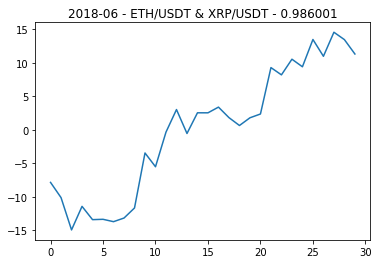

test value : 0.028277


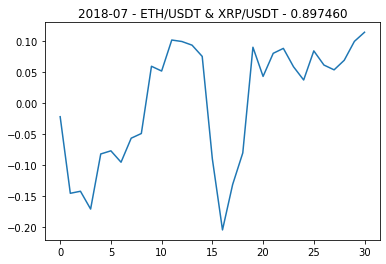

test value : -1.751985


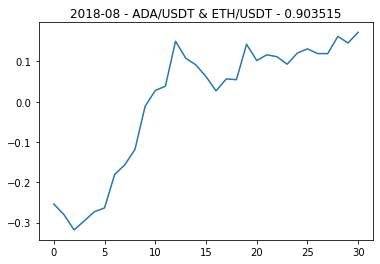

test value : -1.202524


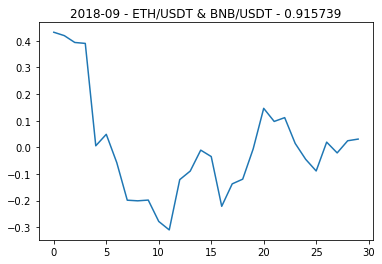

test value : -2.484644


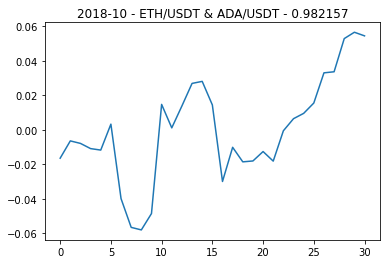

test value : -1.407891


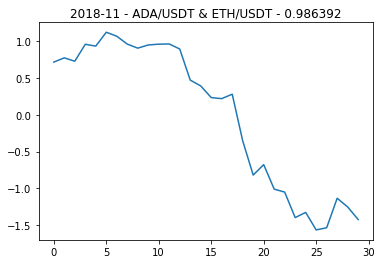

test value : 0.017134


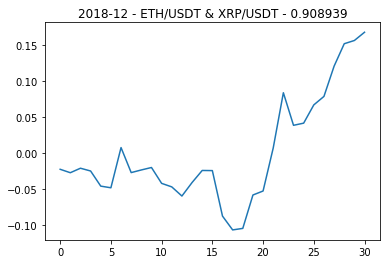

test value : -0.017320


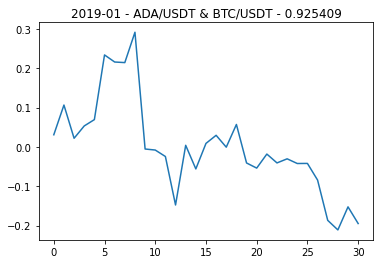

test value : -1.716654


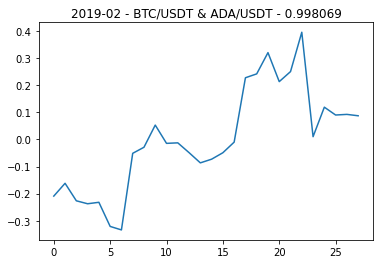

test value : -1.826377


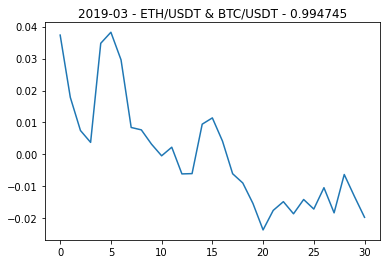

test value : -2.307688


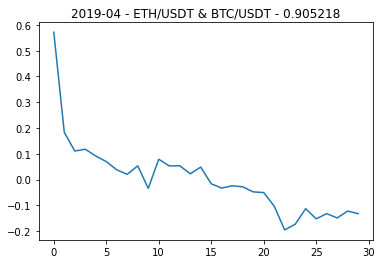

test value : -1.542186


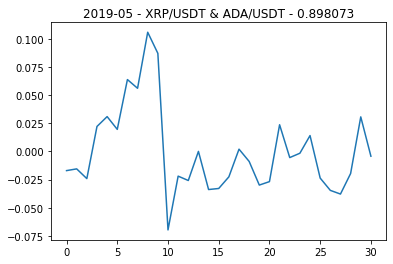

test value : -3.220439


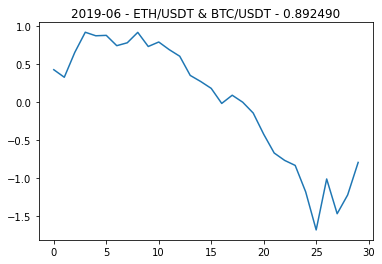

test value : -0.183225


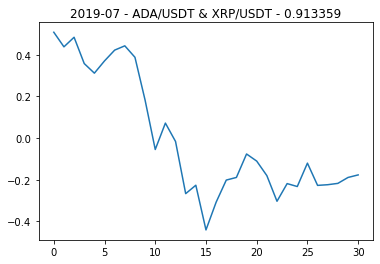

test value : -1.736656


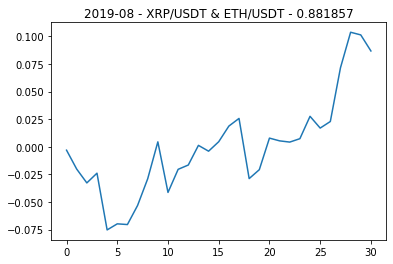

test value : -0.818925


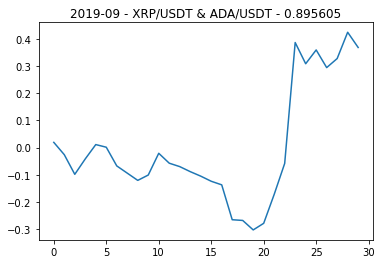

test value : -0.718446


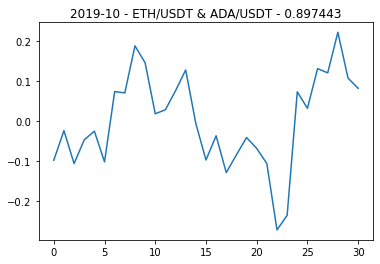

test value : -2.566359


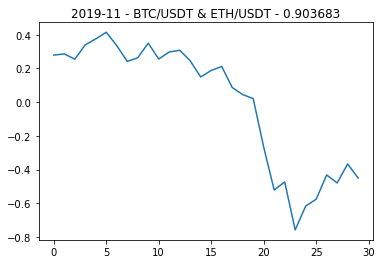

test value : -0.550091


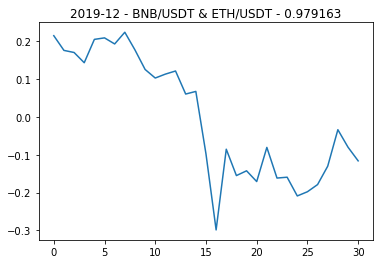

test value : -1.564451


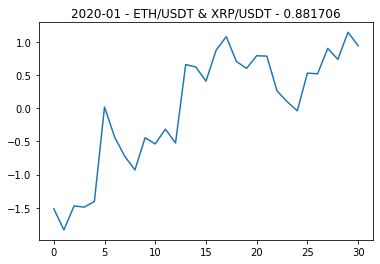

test value : -0.365193


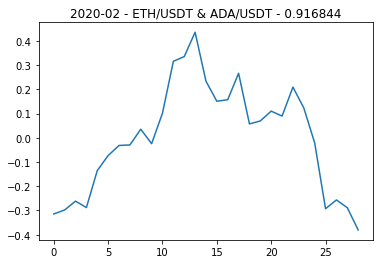

test value : -1.200905


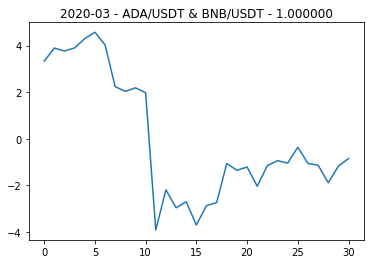

test value : -2.464417


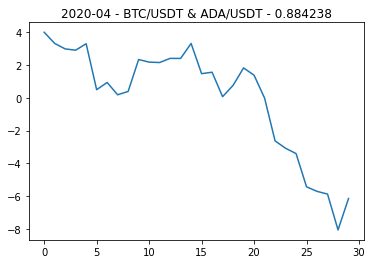

test value : -0.566673


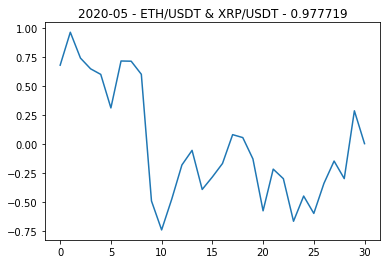

test value : -2.190515


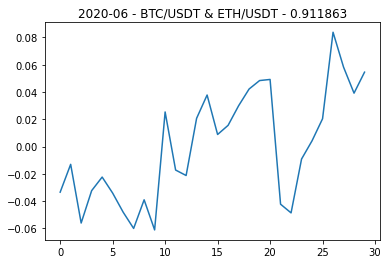

test value : -2.292876


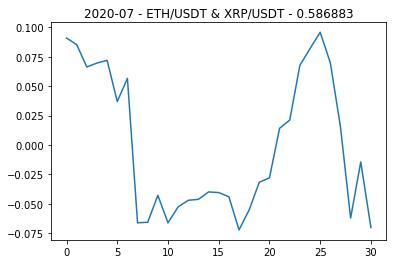

test value : -1.929919


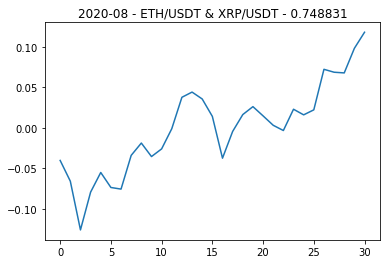

test value : -0.612999


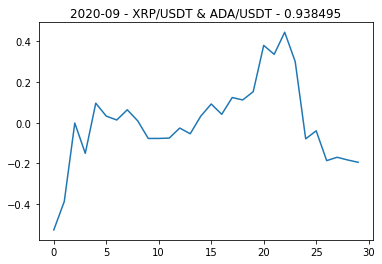

test value : -2.942366


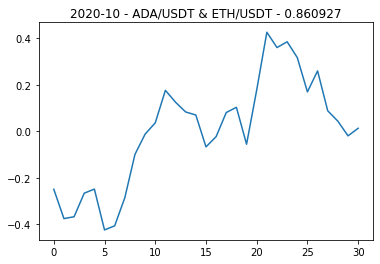

test value : -1.561936


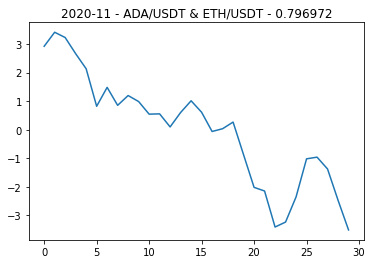

test value : -1.613115


In [29]:
sample_data = []
sample_month = -1

for i in range (len(aggregated_df)-1) : 
    
    if len(sample_data) == 0:
        
        sample_month = datetime.datetime.strptime(aggregated_df.index[i] , '%Y-%m-%d').month
        
    sample_data.append(np.array(aggregated_df.iloc[i]))
    
    next_data_month = datetime.datetime.strptime(aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month :
        
        sample_data_df = pd.DataFrame(np.array(sample_data) , columns = aggregated_df.columns)
        
        sample_data = []
        
        log_sample = np.log(sample_data_df)
        
        log_ret = np.array(log_sample.diff().dropna())
        colname = aggregated_df.columns
        thres = 0.99
        
        factor_ret = PCA_Factor_Model(log_ret , colname , thres)
        selected_pair , distance = Distance_Measure(np.array(factor_ret) , colname)
        selected_factor_ret = factor_ret[selected_pair]
        
        coef , first_asset , second_asset = cointegration_coefficient_factor_corr(np.array(selected_factor_ret) , selected_pair)
        
        spread = log_sample[first_asset] - coef * log_sample[second_asset]
        mean = np.mean(spread)
        spread = spread - mean
        
        plt.title('%s - %s & %s - %f' % ((aggregated_df.index[i][:-3] ,first_asset ,second_asset ,distance )))
        plt.plot(spread)
        plt.show()
        
        best_lag_order = spread_lag_order(spread , 0 , 10)
        
        test_value = ADF_test(spread , best_lag_order)
        
        print('test value : %f' %test_value)
        
        
        

### Plot the Spread formed by TLS (Pair Selection : Distance Measure by APT)

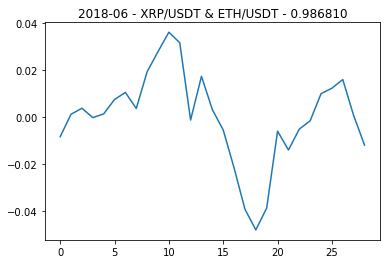

test value : -1.826733


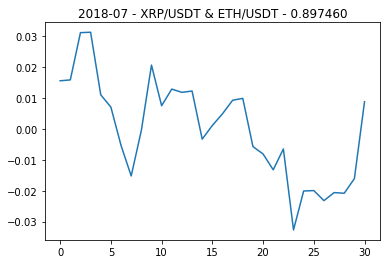

test value : -2.122876


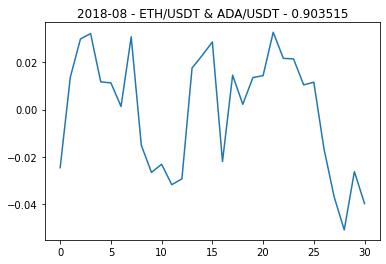

test value : -2.573482


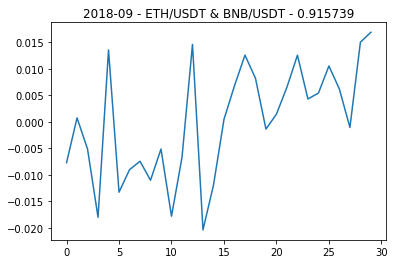

test value : -3.994684


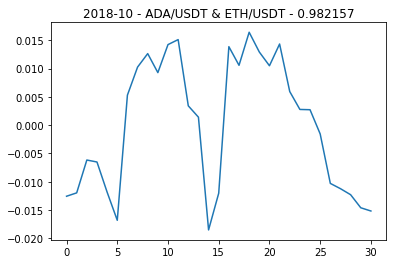

test value : -2.096724


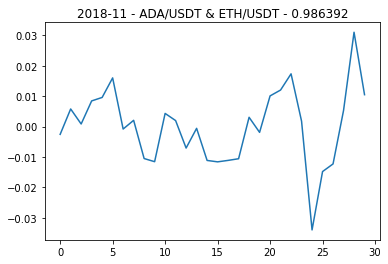

test value : -3.173616


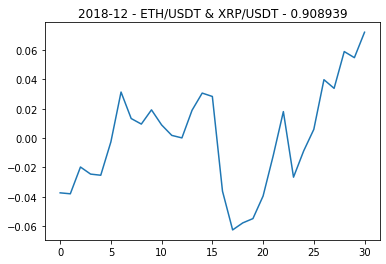

test value : -1.387113


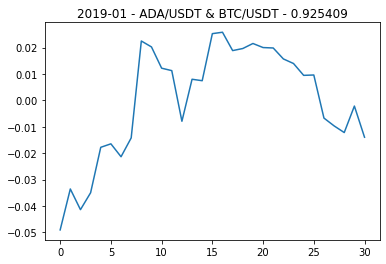

test value : -2.500508


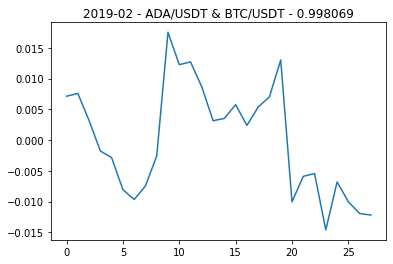

test value : -2.093325


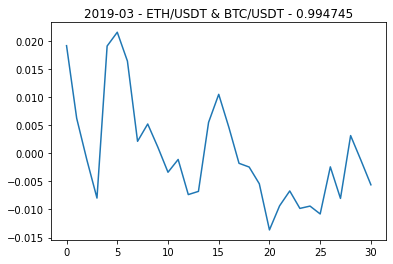

test value : -3.164616


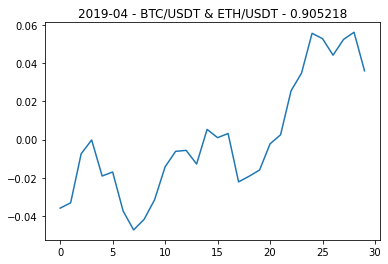

test value : -1.170991


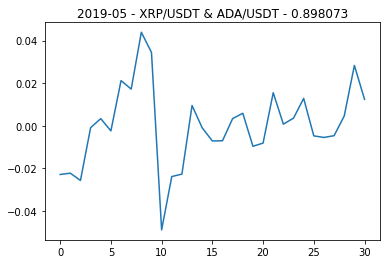

test value : -3.742399


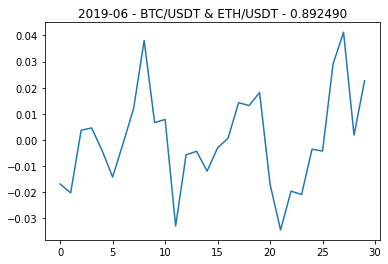

test value : -3.242345


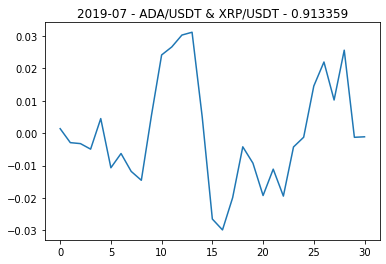

test value : -2.304530


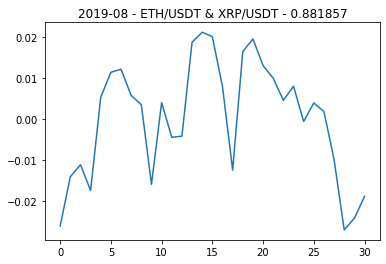

test value : -2.784975


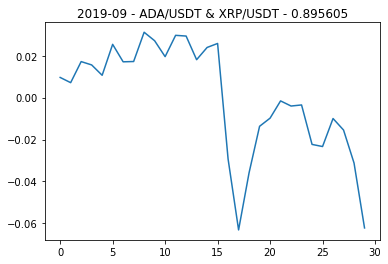

test value : -1.041933


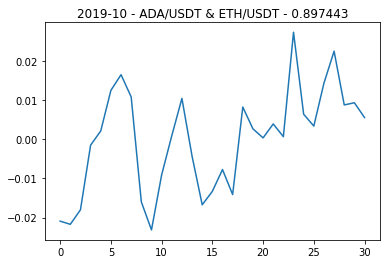

test value : -3.014687


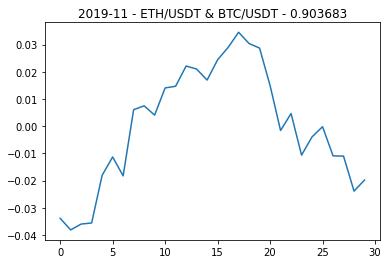

test value : -1.545688


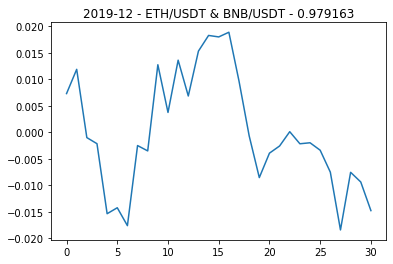

test value : -1.860586


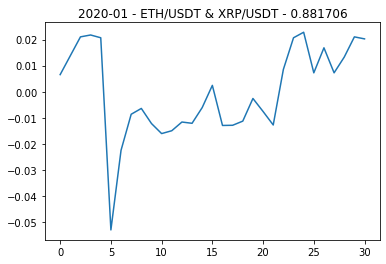

test value : -2.854146


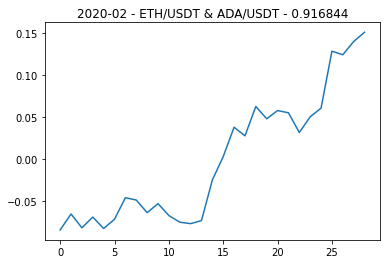

test value : 0.081377


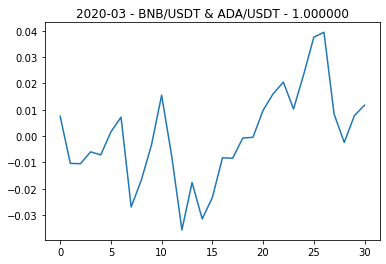

test value : -2.358530


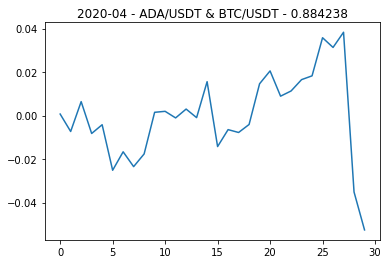

test value : -2.042651


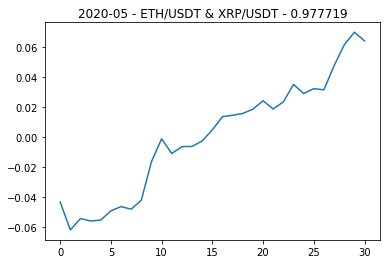

test value : -0.071337


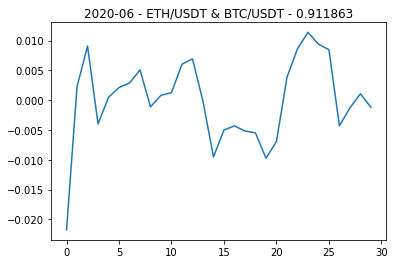

test value : -4.656072


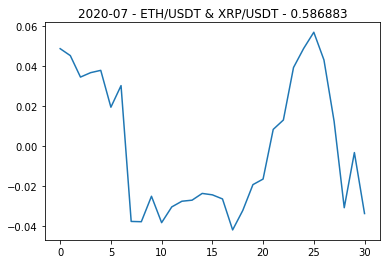

test value : -1.931824


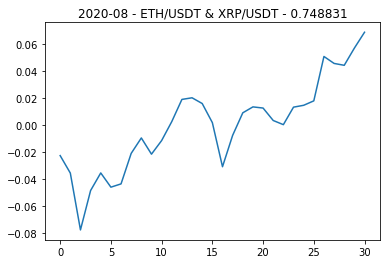

test value : -0.699207


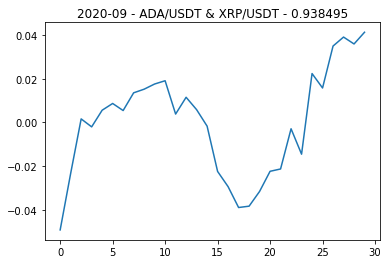

test value : -1.778857


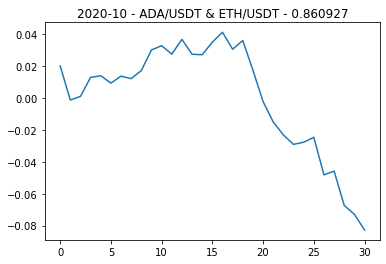

test value : 0.803477


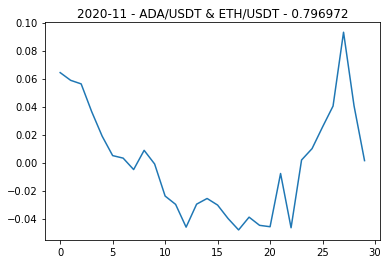

test value : -2.176319


In [44]:
sample_data = []
sample_month = -1

# Scaling the data

scaled_aggregated_df = np.log(aggregated_df[1:]) - np.log(aggregated_df.iloc[0])

for i in range (len(scaled_aggregated_df)-1) : 
    
    if len(sample_data) == 0:
        
        sample_month = datetime.datetime.strptime(scaled_aggregated_df.index[i] , '%Y-%m-%d').month
        
    sample_data.append(np.array(scaled_aggregated_df.iloc[i]))
    
    next_data_month = datetime.datetime.strptime(scaled_aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month :
        
        sample_data_df = pd.DataFrame(np.array(sample_data) , columns = scaled_aggregated_df.columns)
        
        sample_data = []
        
        log_sample = sample_data_df
        
        log_ret = np.array(log_sample.diff().dropna())
        colname = scaled_aggregated_df.columns
        thres = 0.99
        
        factor_ret = PCA_Factor_Model(log_ret , colname , thres)
        selected_pair , distance = Distance_Measure(np.array(factor_ret) , colname)
        
        selected_sample = sample_data_df[selected_pair]
        sign = np.sign(np.cov(selected_sample)[1,0])
        beta_0 , beta_1 , first_asset , second_asset = cointegration_coefficient_TLS(np.array(selected_sample) , sign ,selected_pair)
        
        spread = (selected_sample[first_asset] - beta_0 - beta_1*selected_sample[second_asset])/np.sqrt(1+beta_1**2)
        
        plt.title('%s - %s & %s - %f' % ((scaled_aggregated_df.index[i][:-3] ,first_asset ,second_asset ,distance )))
        plt.plot(spread)
        plt.show()
        
        best_lag_order = spread_lag_order(spread , 0 , 10)
        
        test_value = ADF_test(spread , best_lag_order)
        
        print('test value : %f' %test_value)

### Plot the Spread formed by TLS (Pair Selection : ADF test value)

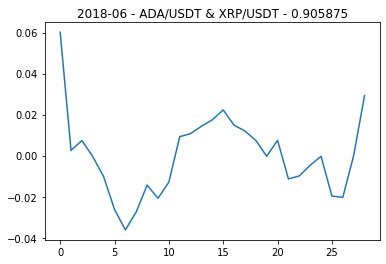

test value : -3.710497


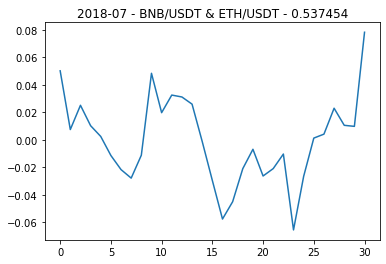

test value : -2.935078


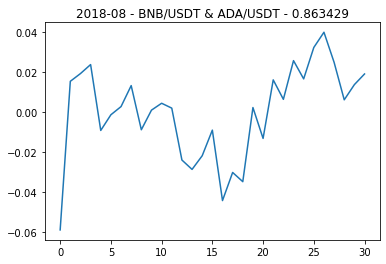

test value : -3.734003


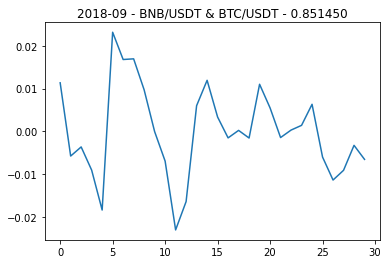

test value : -3.488428


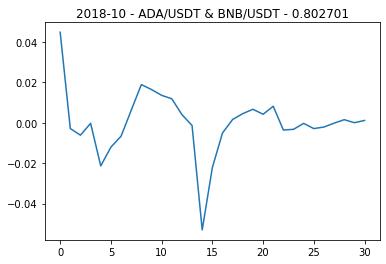

test value : -4.541620


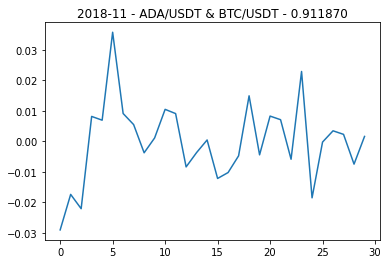

test value : -4.892775


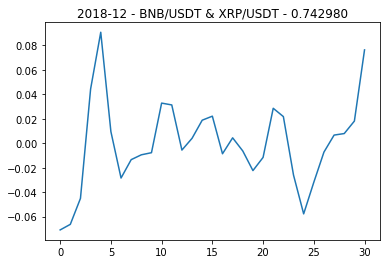

test value : -6.232156


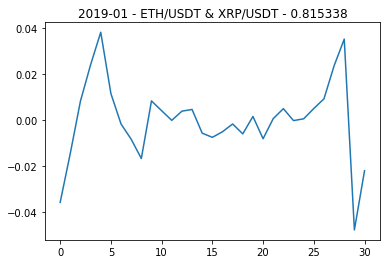

test value : -4.209101


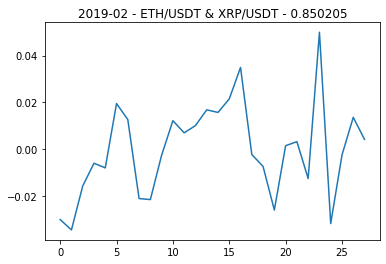

test value : -4.580209


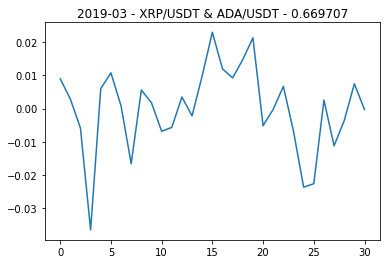

test value : -3.981166


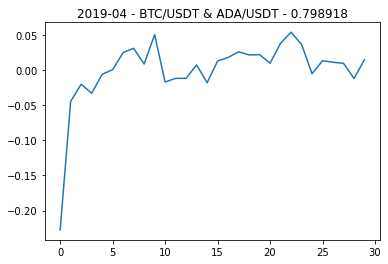

test value : -9.152547


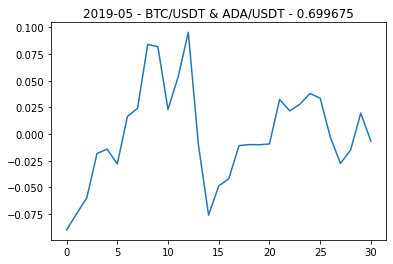

test value : -2.870233


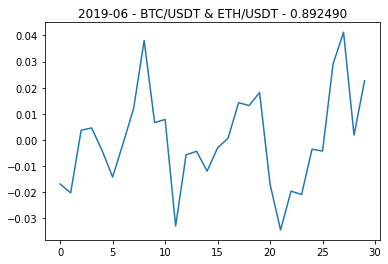

test value : -3.242345


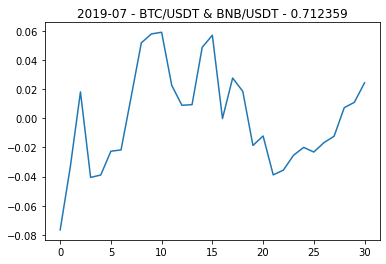

test value : -3.046733


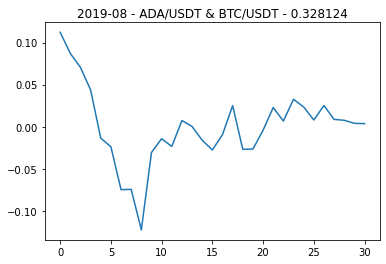

test value : -2.989559


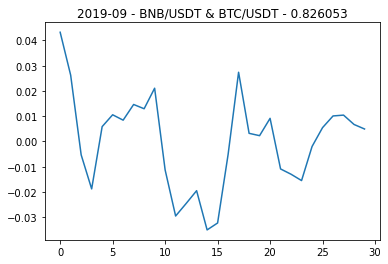

test value : -3.312250


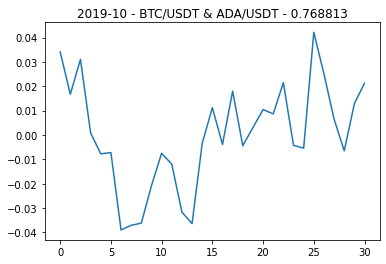

test value : -2.840032


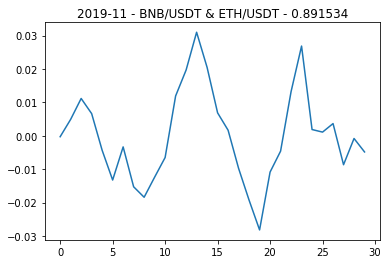

test value : -2.265084


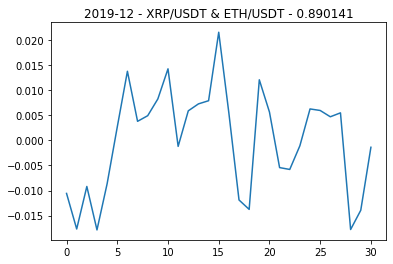

test value : -3.302783


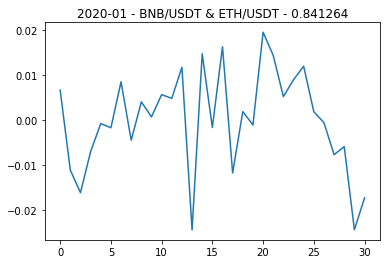

test value : -4.562516


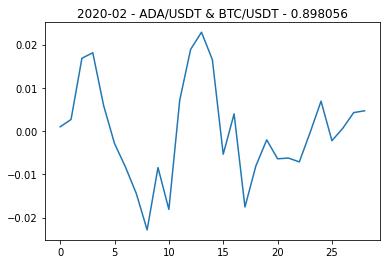

test value : -2.646972


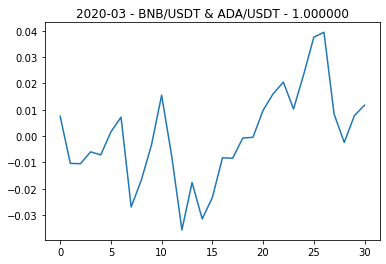

test value : -2.358530


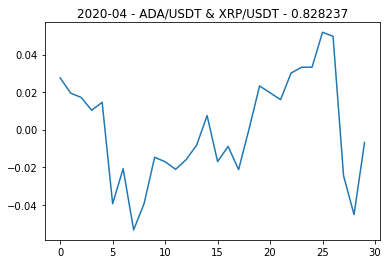

test value : -2.549999


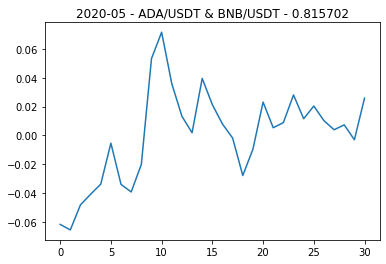

test value : -2.587344


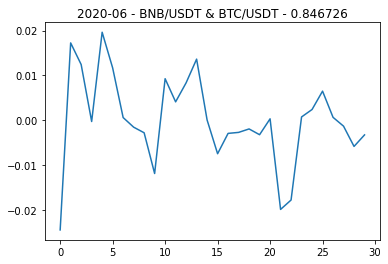

test value : -4.912920


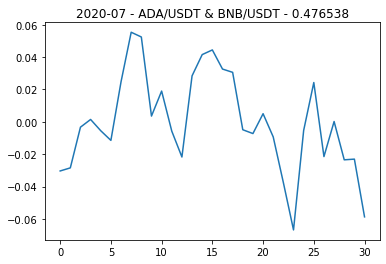

test value : -2.492961


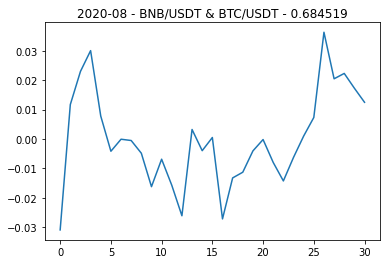

test value : -3.185735


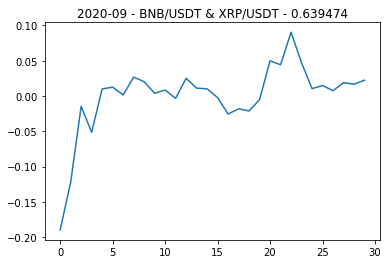

test value : -5.121468


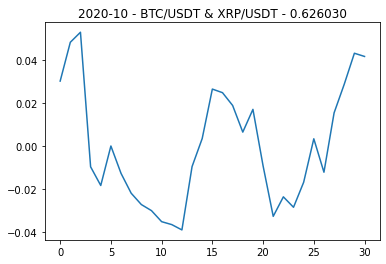

test value : -1.821612


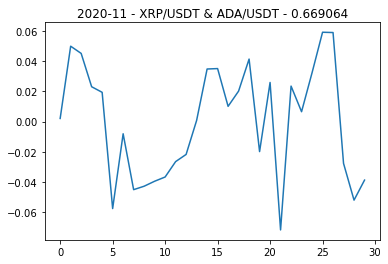

test value : -3.428598


In [60]:
scaled_sample_data = []
sample_data = []
sample_month = -1

# Scaling the data

scaled_aggregated_df = np.log(aggregated_df) - np.log(aggregated_df.iloc[0])

for i in range (1 , len(scaled_aggregated_df)-1) : 
    
    if len(scaled_sample_data) == 0:
        
        sample_month = datetime.datetime.strptime(scaled_aggregated_df.index[i] , '%Y-%m-%d').month
        
    scaled_sample_data.append(np.array(scaled_aggregated_df.iloc[i]))
    sample_data.append(np.array(aggregated_df.iloc[i]))
    
    next_data_month = datetime.datetime.strptime(scaled_aggregated_df.index[i+1] , '%Y-%m-%d').month
    
    if next_data_month != sample_month :
        
        scaled_sample_data_df = pd.DataFrame(np.array(scaled_sample_data) , columns = scaled_aggregated_df.columns)
        sample_data_df = pd.DataFrame(np.array(sample_data) , columns = aggregated_df.columns)
        
        scaled_sample_data = []
        sample_data = []
        
        beta_0 , beta_1 , first_asset , second_asset = ADF_Measure(scaled_sample_data_df)
        
        spread = (scaled_sample_data_df[first_asset] - beta_0 - beta_1*scaled_sample_data_df[second_asset])/np.sqrt(1+beta_1**2)
        
        log_sample = np.log(sample_data_df)
        log_ret = np.array(log_sample.diff().dropna())
        colname = aggregated_df.columns
        thres = 0.99
        factor_ret = PCA_Factor_Model(log_ret , colname , thres)
        
        first_factor_ret = np.array(factor_ret[first_asset]).reshape((len(factor_ret[first_asset]),))
        second_factor_ret = np.array(factor_ret[second_asset]).reshape((len(factor_ret[second_asset]),))
        
        Var_Cov_Mat = np.cov(first_factor_ret , second_factor_ret)
        
        distance = abs(Var_Cov_Mat[1,0]/np.sqrt(Var_Cov_Mat[0,0]*Var_Cov_Mat[1,1]))
        
        plt.title('%s - %s & %s - %f' % ((scaled_aggregated_df.index[i][:-3] ,first_asset ,second_asset,distance)))
        plt.plot(spread)
        plt.show()
        
        best_lag_order = spread_lag_order(spread , 0 , 10)
        
        test_value = ADF_test(spread , best_lag_order)
        
        print('test value : %f' %test_value)